In [1]:
import torch
print("Is CUDA enabled?",torch.cuda.is_available())

Is CUDA enabled? False


In [2]:
import ijson
import os
from setuptools import setup

def parse_large_json(file_path):
    # Открытие файла для потоковой обработки
    answ_list = []

    with open(file_path, 'rb') as file:
        # Потоковая обработка элементов JSON
        parser = ijson.parse(file)

        for prefix, event, value in parser:
            # тут нас интересуют элементы списков в json и событие по нахождению какого-либо ключа в этом списке
            if prefix.endswith('.item') and event == 'map_key':
                # заготовка под объект json, который будем строить
                json_object = {}
                # пока в текущем списке есть элементы, будем их анализировать

                while event == 'map_key':
                    # ijson идет итеративно по ключам и значениям
                    # поэтому сначала сохраняем уже полученный ключ,
                    # а потом запускаем следующую итерацию для получения значения
                    key = value
                    _, _, value = next(parser)
                        

                    answ_list.append(value)
                    json_object[key] = value
                    # для продолжения нашего while нам нужно снова перейти на следующий ключ списка
                    # поэтому в этой итерации мы специально сеттим event (там как раз будет map_key)
                    prefix, event, value = next(parser)

                # с построенным объектом json можем делать что угодно, тут мы сверяем его с фильтром и записываем

    return answ_list

# full_dir - полный путь до json файлов
full_dir = os.path.dirname(os.path.realpath('__file__'))

answers = parse_large_json(full_dir + '/answers.json')
questions = parse_large_json(full_dir + '/questions.json')

print('Количество вопросов: ', len(questions))
print('Количество ответов: ', len(answers))


Количество вопросов:  31141
Количество ответов:  31141




### Разбиение данных

In [3]:
from sklearn.model_selection import train_test_split
import numpy as np

# chunk_size = 2831 # разбиваем наши вопросы/ответы на 11 равных частей
# chunk_size = 149 # разбиваем наши вопросы/ответы на 209 равных частей
chunk_size = 60 # разбиваем наши вопросы/ответы на 520 частей
questions_chunks = np.array_split(questions, len(questions) // chunk_size)
answers_chunks = np.array_split(answers, len(answers) // chunk_size)

questions_train = []
questions_val = []
answers_train = []
answers_val = []

# Разбиение датасета на обучающий и валидационный наборы
# В этом примере `test_size=0.1` указывает, что 10% данных будут использоваться для валидации, а оставшиеся 90% — для обучения. `random_state` обеспечивает воспроизводимость разбиения

for i in range(len(questions_chunks)):
    questions_train_chunk, questions_val_chunk, answers_train_chunk, answers_val_chunk = train_test_split(
        questions_chunks[i], answers_chunks[i], test_size=0.1, random_state=42
    )
    questions_train.append(questions_train_chunk)
    questions_val.append(questions_val_chunk)
    answers_train.append(answers_train_chunk)
    answers_val.append(answers_val_chunk)

# Создаем список меток, 0 или 1, в зависимости от того, насколько хорошо ответ соответствует вопросу
labels_list = [1] * len(questions_chunks[0]) # по умолчанию считаем, что все ответы соответствуют вопросу

print('Количество вопросов на обучение: ', len(questions_train[0]), 'в ', len(questions_chunks) , 'чанков')
print('Количество ответов на обучение: ', len(answers_train[0]), 'в ', len(answers_chunks) , 'чанков')

print('Количество вопросов на валидацию: ', len(questions_val[0]), 'в ', len(questions_chunks) , 'чанков')
print('Количество ответов на валидацию: ', len(answers_val[0]), 'в ', len(answers_chunks) , 'чанков')

Количество вопросов на обучение:  54 в  519 чанков
Количество ответов на обучение:  54 в  519 чанков
Количество вопросов на валидацию:  7 в  519 чанков
Количество ответов на валидацию:  7 в  519 чанков


Чтобы получить train_dataloader и val_dataloader для обучения и валидации модели BERT мы подготавливаем данные, токенизируем их и обварачиваем в DataLoader объекты из PyTorch. DataLoader позволяет итерировать по датасету с заданным размером батча.

### Подготовка и токенизация данных

Для начала токенизируем вопросы и ответы. Заготовленные данные questions_train, answers_train, questions_val, и answers_val у нас уже есть.


In [4]:
from transformers import BertTokenizer
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def encode_questions_answers(questions, answers, tokenizer, max_length=512):
    input_ids = []
    attention_masks = []

    for question, answer in zip(questions, answers):
        encoded_dict = tokenizer.encode_plus(
            text=question,  # Вопрос для кодирования
            text_pair=answer,  # Ответ для кодирования
            add_special_tokens=True,  # Добавление '[CLS]' и '[SEP]'
            max_length=max_length,  # Ограничение длины входных данных
            padding='max_length', # Добавление паддинга до max_length
            return_attention_mask=True,  # Возврат маски внимания
            return_tensors='pt',  # Возврат pytorch тензоров
        )
        
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks

# Кодирование данных обучения и валидации
input_ids_train, attention_masks_train = encode_questions_answers(questions_train[0], answers_train[0], tokenizer)
input_ids_val, attention_masks_val = encode_questions_answers(questions_val[0], answers_val[0], tokenizer)


### Важные моменты:

- Указываем max_length в encode_plus, соответствующую ограничениям нашей модели (например, 512 для BERT).
- Если нет меток (labels_train и labels_val), то необходимо их создать в соответствии с задачей (например, классификация или вопросно-ответная система).
- Размер батча (batch_size) можно настроить в зависимости от объема доступной памяти на устройстве. Больший размер батча ускоряет обучение, но требует больше памяти.

С этими DataLoader объектами можно выполнять обучение модели

- num_workers определяет количество процессов для параллельной загрузки данных. Увеличение этого значения может ускорить подготовку данных, но требует больше ресурсов CPU.
- pin_memory позволяет DataLoader помещать тензоры непосредственно в область памяти, которая будет "закреплена" (pinned), что ускоряет их последующую передачу на GPU.


In [5]:
def flat_accuracy(preds, labels):
    pred_flat = torch.argmax(preds, dim=1).flatten()
    labels_flat = labels.flatten()
    return torch.sum(pred_flat == labels_flat).item() / len(labels_flat)

### Получение значений потерь и точности

Чтобы получить значения потерь и точности (или других метрик) на этапах обучения и валидации, нам нужно вычислить их по окончании каждой эпохи обучения.


In [6]:
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], [] # инициализация списков для хранения метрик


Цикл по эпохам обучения, где мы будем вычислять потери и точность на обучающем и валидационном наборах данных:


In [7]:
import torch
from torch.utils.data import DataLoader
from transformers import BertForSequenceClassification, BertTokenizer, AdamW
import torch.nn as nn

num_epochs = 50
batch_size = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class QADataset(torch.utils.data.Dataset):
    def __init__(self, questions, answers, tokenizer, labels=None, max_length=512):
        self.questions = questions
        self.answers = answers
        self.tokenizer = tokenizer
        self.labels = labels
        self.max_length = max_length

    def __len__(self):
        return len(self.questions)

    def __getitem__(self, idx):
        encoding = self.tokenizer.encode_plus(
            self.questions[idx],
            self.answers[idx],
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        item = {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten()
        }

        if self.labels:
            item['labels'] = torch.tensor(self.labels[idx])

        return item

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_dataset = QADataset(questions_train[0], answers_train[0], tokenizer, labels_list)
val_dataset = QADataset(questions_val[0], answers_val[0], tokenizer, labels_list)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2).to(device)

optimizer = AdamW(model.parameters(), lr=5e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)  # Уменьшение learning rate каждые 5 эпох

criterion = nn.CrossEntropyLoss()

for epoch in range(num_epochs):
    model.train()
    total_loss, total_accuracy = 0, 0
    
    for batch in train_dataloader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch.get('labels', None)
        
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        logits = outputs.logits
        loss = criterion(logits.view(-1, 2), labels.view(-1)) if labels is not None else outputs.loss

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        if labels is not None:
            total_accuracy += flat_accuracy(logits, labels)

    avg_train_loss = total_loss / len(train_dataloader)
    avg_train_accuracy = total_accuracy / len(train_dataloader)

    # Валидация
    model.eval()
    total_loss, total_accuracy = 0, 0
    
    with torch.no_grad():
        for batch in val_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch.get('labels', None)
            
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            logits = outputs.logits
            loss = criterion(logits.view(-1, 2), labels.view(-1)) if labels is not None else outputs.loss

            total_loss += loss.item()
            if labels is not None:
                total_accuracy += flat_accuracy(logits, labels)

    avg_val_loss = total_loss / len(val_dataloader)
    avg_val_accuracy = total_accuracy / len(val_dataloader)

    scheduler.step()

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Train Accuracy: {avg_train_accuracy:.4f}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {avg_val_accuracy:.4f}')
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(avg_train_accuracy)
    val_accuracies.append(avg_val_accuracy)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.9/site-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/50, Train Loss: 0.6683, Train Accuracy: 0.6296, Validation Loss: 0.3295, Validation Accuracy: 1.0000
Epoch 2/50, Train Loss: 0.3318, Train Accuracy: 1.0000, Validation Loss: 0.2369, Validation Accuracy: 1.0000
Epoch 3/50, Train Loss: 0.2394, Train Accuracy: 1.0000, Validation Loss: 0.1923, Validation Accuracy: 1.0000
Epoch 4/50, Train Loss: 0.2048, Train Accuracy: 1.0000, Validation Loss: 0.1416, Validation Accuracy: 1.0000
Epoch 5/50, Train Loss: 0.1462, Train Accuracy: 1.0000, Validation Loss: 0.1064, Validation Accuracy: 1.0000
Epoch 6/50, Train Loss: 0.1179, Train Accuracy: 1.0000, Validation Loss: 0.1037, Validation Accuracy: 1.0000
Epoch 7/50, Train Loss: 0.1053, Train Accuracy: 1.0000, Validation Loss: 0.1002, Validation Accuracy: 1.0000
Epoch 8/50, Train Loss: 0.1030, Train Accuracy: 1.0000, Validation Loss: 0.0965, Validation Accuracy: 1.0000
Epoch 9/50, Train Loss: 0.1024, Train Accuracy: 1.0000, Validation Loss: 0.0927, Validation Accuracy: 1.0000
Epoch 10/50, Train 

In [8]:
def prepare_encodings(tokenizer, question, answer, device, max_length=512):
    # Объединяем вопрос и ответ в одну последовательность
    encoding = tokenizer.encode_plus(
        question,
        answer,
        add_special_tokens=True, # Добавляет токены [CLS] и [SEP]
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt',
    )
    return encoding.to(device)

1. Использование logits для оценки релевантности: для модели классификации `logits` будет содержать значения для каждого класса. Мы можем интерпретировать эти значения как меру уверенности модели в том, что пара вопрос-ответ принадлежит к определенному классу (например, классу "релевантный" и "нерелевантный").

2. Выбор класса и использование софтмакса для преобразования logits в вероятности: применение функции софтмакс к logits дает нам вероятности принадлежности к каждому классу.


In [9]:
def find_most_relevant_answer(model, tokenizer, question, answers, device):
    model.eval()
    model.to(device)
    
    max_relevance = float('-inf')
    most_relevant_answer = ""
    
    for answer in answers:
        inputs = tokenizer.encode_plus(question, answer, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        
        logits = outputs.logits
        # Применяем софтмакс для получения вероятностей
        probs = F.softmax(logits, dim=1)
        # Предполагаем, что класс 1 соответствует "релевантности"
        relevance = probs[:, 1]  # выбираем вероятность класса "релевантный"
        
        if relevance > max_relevance:
            max_relevance = relevance
            most_relevant_answer = answer
            
    return most_relevant_answer

In [10]:
# # Наши записанные ответы в answers:
# print("Записанные ответы:", answers)

# # Наши записанные вопросы в answers:
# print("Записанные вопросы:", questions)

# validation_questions = ["При каких обстоятельствах возникает исключение IndexError?", 
#                         "Когда возникает исключение NotImplementedError?",
#                         "Как проверить, что один кортеж содержит все элементы другого кортежа?",
#                         "Чувствителен ли Python к регистру?",
#                         "Что такое модули Python?",
#                         "Объясните, что означает «self» в Python."]


# for question in validation_questions:
#     most_relevant_answer = find_most_relevant_answer(model, tokenizer, question, answers, device)
#     print("Задаваемый вопрос: ", question)
#     print(" Ответ: ", most_relevant_answer, "\n")



### Построение графиков потерь и точности


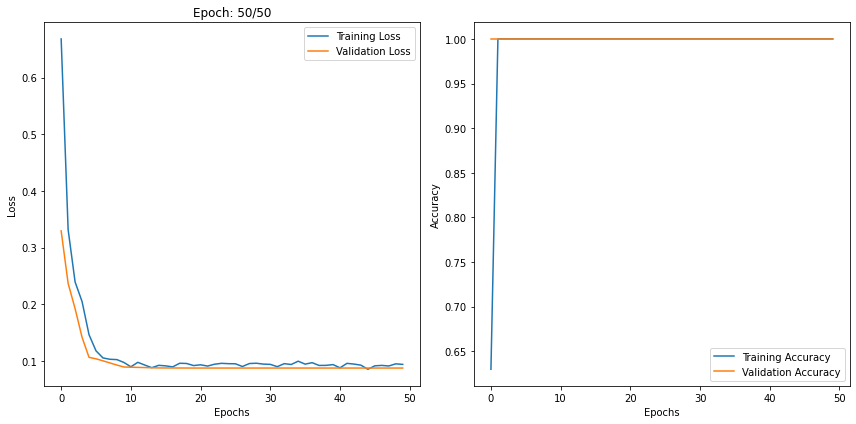

In [11]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

# train_losses = []  # Список для хранения значений потерь на обучающем наборе
# val_losses = []  # Список для хранения значений потерь на валидационном наборе
# train_accuracies = []  # Список для хранения значений точности на обучающем наборе
# val_accuracies = []  # Список для хранения значений точности на валидационном наборе


for epoch in range(num_epochs):
    clear_output(wait=True)
    plt.figure(figsize=(12, 6))

    # График потерь
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Epoch: {}/{}'.format(epoch + 1, num_epochs))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # График точности
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()
